In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver

matplotlib.rcParams.update({'font.size': 14,  # General font size
                 'axes.labelsize': 14,  # Axis label size
                 'axes.titlesize': 14,  # Title size
                 'xtick.labelsize': 14,  # X-tick label size
                 'ytick.labelsize': 14,  # Y-tick label size
                 'legend.fontsize': 14})  # Legend font size


print(jax.devices())


[CudaDevice(id=0)]


In [ ]:
# Problem setup
nx = 256
nv = 256
deltat  = 0.1
problem = 'ts'
t_final = 40  # Adjusted for demonstration purposes

In [4]:
nx = 256
nv = 256
dt  = 0.1
t_final = 40  # Adjusted for demonstration purposes

mesh = make_mesh(10*jnp.pi, 6.0, nx, nv)

L = 10*jnp.pi
LV = 6.0
alpha = 0.5
mu1 = 2.4
mu2 = -2.4
f_eq = (alpha * jnp.exp(-0.5*(mesh.V-mu1)**2) + (1 - alpha) * jnp.exp(-0.5*(mesh.V-mu2)**2))/jnp.sqrt(2*jnp.pi)
epsilon = 0.001
k_0 = 0.2
f_iv = (1.0 + epsilon*jnp.cos(k_0*mesh.X)) * f_eq
H = jnp.zeros((len(mesh.xs),))

num_steps = int(t_final/dt)

# Function to plot the distribution of f_eq over x and v
def plot_feq_distribution(ax, f_eq, title):
    im = ax.imshow(f_eq.transpose(), extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='viridis')  # 'auto' aspect ratio
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

# Function to plot the distribution
def plot_distribution(ax, data, index, title, time):
    im = ax.imshow(data[index].transpose(), extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto')  # 'auto' aspect ratio
    ax.set_title(f'{title} (t={time:.2f})')
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size


solver = VlassovPoissonSolver(mesh=mesh, dt=dt, f_eq=jnp.array(f_eq))

# f_array = solver.run_forward(jnp.array(f_iv), H, t_final=1.0)

In [5]:
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

In [6]:
f_final, (f_array, E_array, ee_array) = solver_jit(jnp.array(f_iv), jnp.array(H), t_final=t_final)

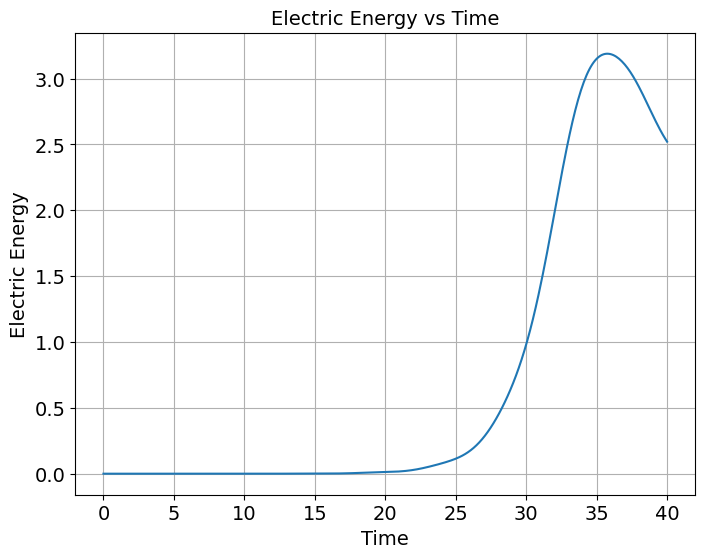

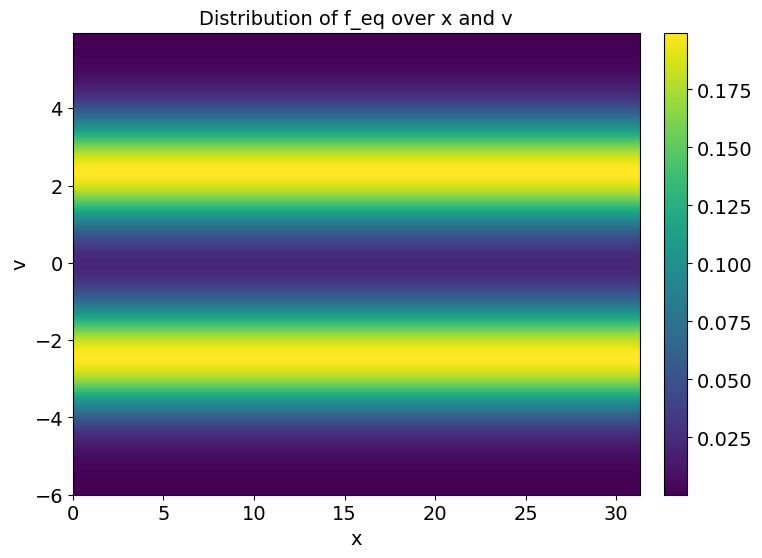

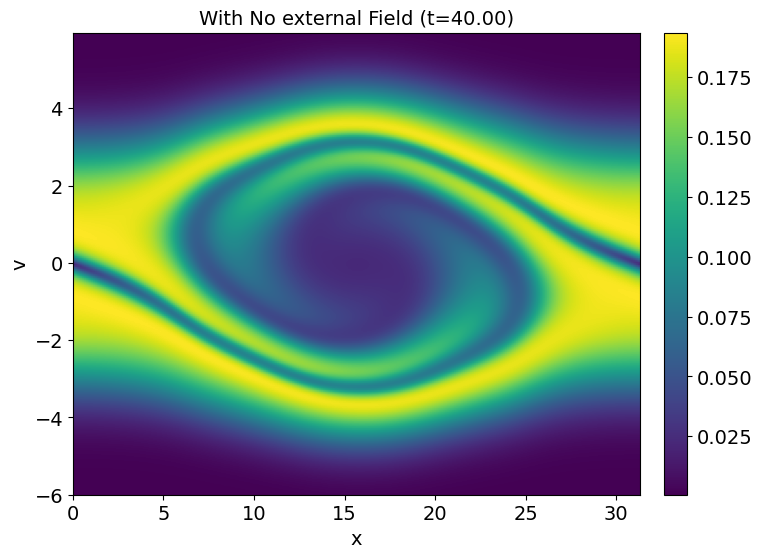

In [7]:
# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))
t_values = jnp.linspace(0, t_final, int(t_final/dt))

plt.plot(t_values, ee_array)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution for the final step with the external field
plot_distribution(ax, f_array, num_steps - 1, 'With No external Field', t_final)

# Display the plot
plt.show()

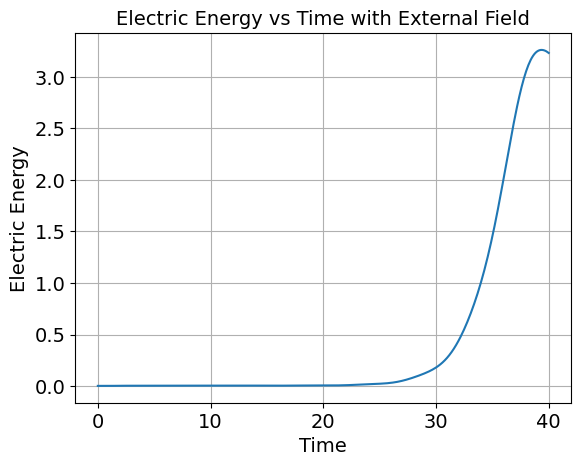

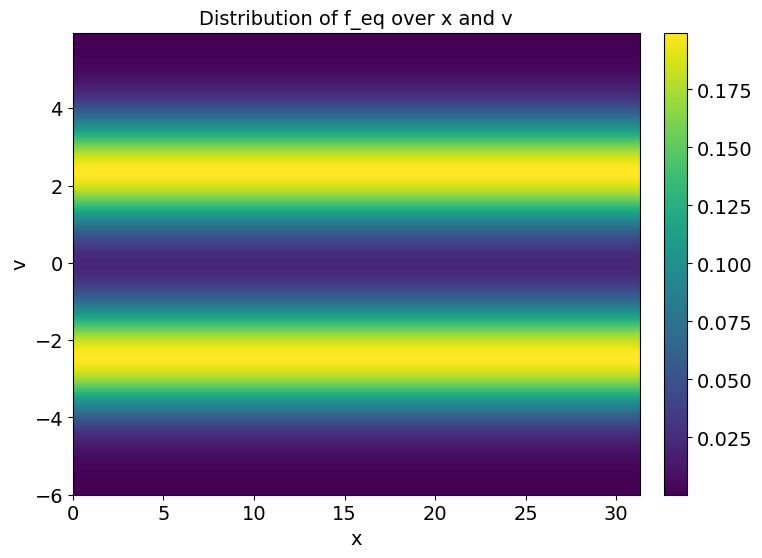

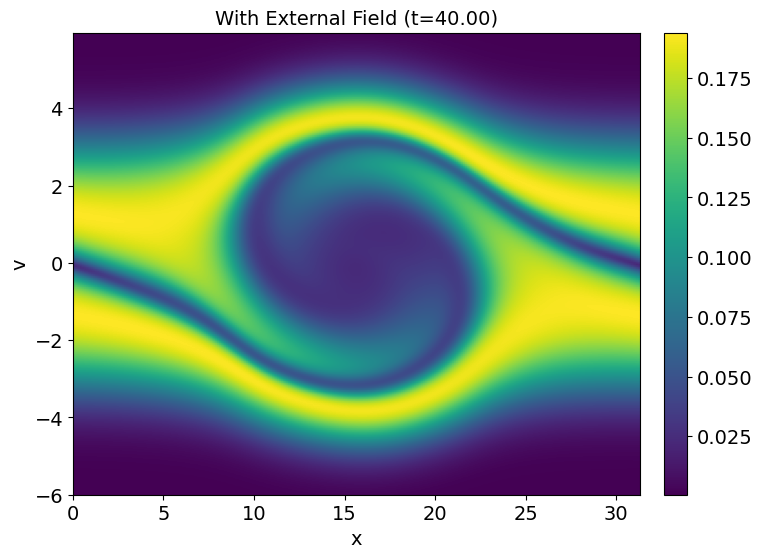

In [8]:
# External field parameters (coefficients for the cosine terms)
a_k = [-0.00000591, 0.00003512, -0.00134810, 0.01075167, -0.01016702]

# Function to compute the external field H (not time-dependent)
def compute_external_field(xs, a_k):
    H = np.zeros(len(xs))  # Initialize H as a 1D array (space)
    for k in range(1, 6):  # Iterate over k from 1 to 5
        H += a_k[k-1] * np.cos(k *xs/L*2*np.pi)  # Compute H for each k and sum
    return H

# Compute H using the given a_k values
H = compute_external_field(mesh.xs, a_k)

# Run the forward simulation with the external field
f_final, (f_array, E_array, ee_array) = solver_jit(jnp.array(f_iv), jnp.array(H), t_final=40.0)

# Plotting the electric energy with respect to time
plt.plot(t_values, ee_array)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time with External Field')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution for the final step with the external field
plot_distribution(ax, f_array, num_steps - 1, 'With External Field', t_final)

# Display the plot
plt.show()


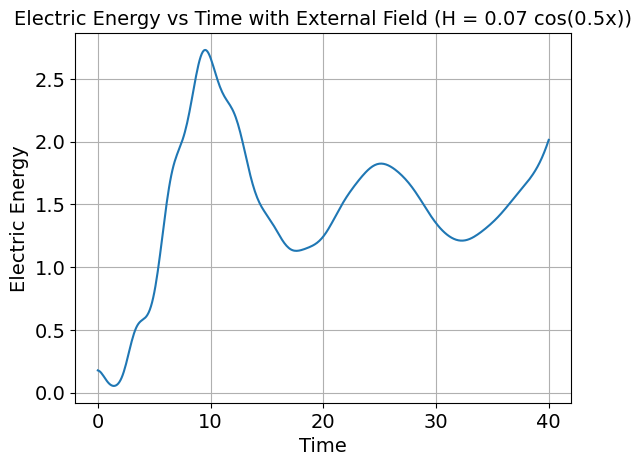

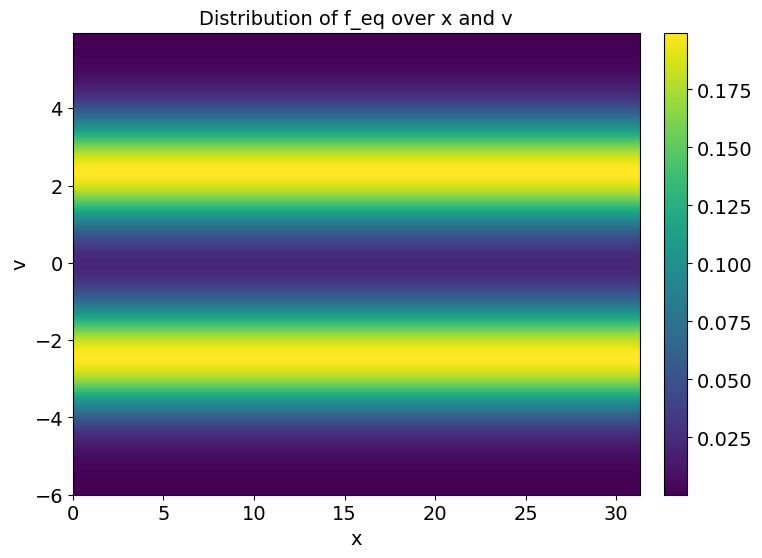

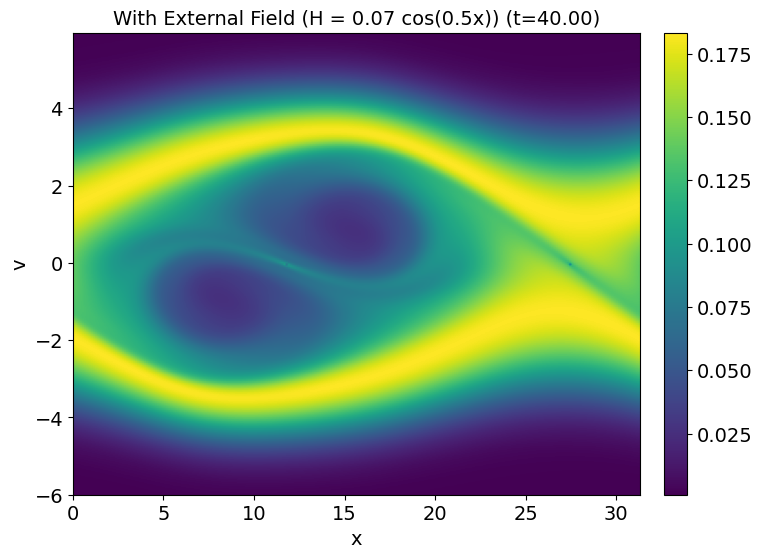

In [9]:
# # Setting H using the new formula
# H = compute_external_field(xs, num_steps)
H = 0.15 * np.cos(2 * 2 * np.pi / L * mesh.xs)

# Run the forward simulation with the updated external field
f_final, (f_array, E_array, ee_array) = solver_jit(jnp.array(f_iv), jnp.array(H), t_final=40.0)

# Plotting the electric energy with respect to time
plt.plot(t_values, ee_array)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time with External Field (H = 0.07 cos(0.5x))')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution for the final step with the external field
plot_distribution(ax, f_array, num_steps - 1, 'With External Field (H = 0.07 cos(0.5x))', t_final)

# Display the plot
plt.show()


In [10]:
def calculate_kl_divergence(f_final, f_eq):
    f_final_flat = f_final.flatten()
    f_eq_flat = f_eq.flatten()

    # Avoid division by zero or log(0) by adding a small constant (machine epsilon)
    kl_divergence = scipy.stats.entropy(f_final_flat + np.finfo(float).eps, f_eq_flat + np.finfo(float).eps)
    return kl_divergence

In [11]:
# Landscape search for H with varying a_1, a_2, and a_3
def run_landscape_search_3d(f_iv, f_eq, a_1_values, a_2_values, a_3_values):
    nx = nv = 256
    L = 10 * jnp.pi
    results = []

    # Nested loop over a_1, a_2, and a_3
    for a_1 in a_1_values:
        for a_2 in a_2_values:
            for a_3 in a_3_values:
                # Define H for the current a_1, a_2, and a_3
                xs = np.linspace(0, L, nx, endpoint=False)
                H = a_1 * np.cos(xs / L * 2 * np.pi) +\
                     a_2 * np.cos(2 * xs / L * 2 * np.pi) +\
                     a_3 * np.cos(3 * xs / L * 2 * np.pi)

                # Run the simulation with this H
                #t_final, fs, ees, Es, xs, vs, num_steps, f_eq = setup_and_run_simulation_two_stream(H)
                f_final, (f_array, E_array, ee_array) = solver_jit(jnp.array(f_iv), jnp.array(H), t_final=t_final)
                
                # Get the final distribution
                #f_final = fs[num_steps - 1]

                # Calculate KL divergence between the final distribution and the equilibrium distribution
                kl_div = calculate_kl_divergence(f_final, f_eq)

                #print(f"KL divergence for a_1 = {a_1}, a_2 = {a_2}, a_3 = {a_3}: {kl_div}")

                # Record the result (a_1, a_2, a_3, KL divergence)
                results.append((a_1, a_2, a_3, kl_div))

    return results

# Find the minimum KL divergence and corresponding (a_1, a_2, a_3)
def find_min_kl_divergence(results):
    min_kl_result = min(results, key=lambda r: r[3])  # r[3] is the KL divergence
    return min_kl_result

# Plot the 2D landscape search results for KL divergence vs (a_2, a_3) at the given a_1
def plot_2d_landscape_at_a1(results, a_1_target):
    filtered_results = [r for r in results if r[0] == a_1_target]
    a_2_values = sorted(list(set([r[1] for r in filtered_results])))
    a_3_values = sorted(list(set([r[2] for r in filtered_results])))

    # Create a grid of KL divergence values
    kl_divergences = np.zeros((len(a_2_values), len(a_3_values)))

    for r in filtered_results:
        a_2_idx = a_2_values.index(r[1])
        a_3_idx = a_3_values.index(r[2])
        kl_divergences[a_2_idx, a_3_idx] = r[3]

    # Create a heatmap for the KL divergence landscape at the given a_1
    plt.figure(figsize=(10, 6))
    plt.contourf(a_2_values, a_3_values, kl_divergences.T, levels=20, cmap='viridis')
    plt.colorbar(label='KL Divergence')
    plt.xlabel('a_2')
    plt.ylabel('a_3')
    plt.title(f'2D Landscape Search: KL Divergence vs (a_2, a_3) at a_1 = {a_1_target}')
    plt.grid(True)
    plt.show()

In [12]:
# Define the ranges for a_1, a_2, and a_3
a_1_values = np.linspace(-0.005, 0.005, 11)  # Step size 0.001
a_2_values = np.linspace(0, 0.15, 16)         # Step size 0.1
a_3_values = np.linspace(-0.05, 0.05, 11)    # Step size 0.01

# Perform the 3D landscape search for a_1, a_2, and a_3
results = run_landscape_search_3d(f_iv, f_eq, a_1_values, a_2_values, a_3_values)

Minimum KL divergence found at: a_1 = 0.002, a_2 = 0.08, a_3 = -0.010000000000000002, KL = 0.04733128845691681


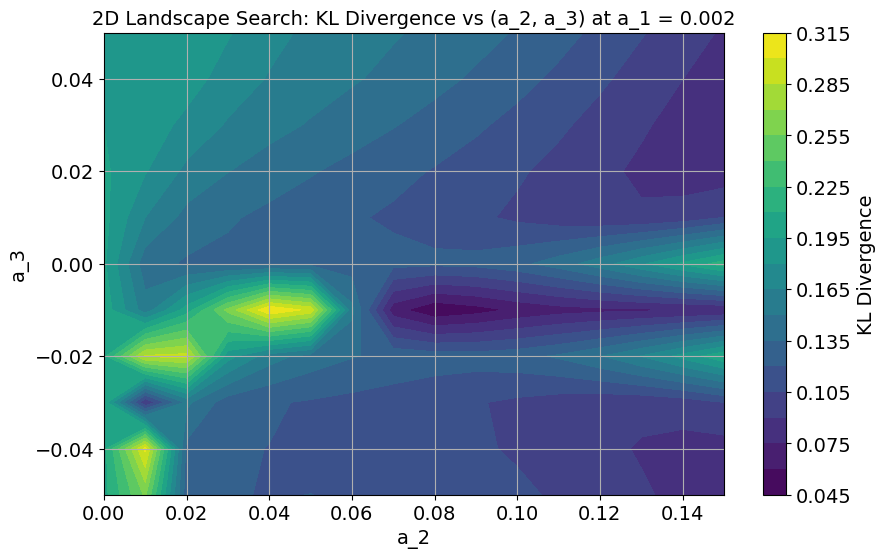

In [13]:
# Find the combination of (a_1, a_2, a_3) with the smallest KL divergence
min_kl_result = find_min_kl_divergence(results)
print(f"Minimum KL divergence found at: a_1 = {min_kl_result[0]}, a_2 = {min_kl_result[1]}, a_3 = {min_kl_result[2]}, KL = {min_kl_result[3]}")

# Plot the 2D landscape for a_2 and a_3 at the corresponding value of a_1
plot_2d_landscape_at_a1(results, min_kl_result[0])

In [14]:
# 2D search for H with fixed a_1, a_2, and a_3, and varying a_4 and a_5
def run_landscape_search_2d_fixed_a1_a2_a3(f_iv, f_eq, a_4_values, a_5_values):
    nx = nv = 256
    L = 10 * np.pi
    results = []

    # Fixed values for a_1, a_2, and a_3
    a_1 = 0
    a_2 = 0.01
    a_3 = -0.01

    # Nested loop over a_4 and a_5
    for a_4 in a_4_values:
        for a_5 in a_5_values:
            # Define H for the current a_4 and a_5
            xs = np.linspace(0, L, nx, endpoint=False)
            H = (a_1 * np.cos(xs / L * 2 * np.pi) +
                 a_2 * np.cos(2 * xs / L * 2 * np.pi) +
                 a_3 * np.cos(3 * xs / L * 2 * np.pi) +
                 a_4 * np.cos(4 * xs / L * 2 * np.pi) +
                 a_5 * np.cos(5 * xs / L * 2 * np.pi))

            # Run the simulation with this H
            #t_final, fs, ees, Es, xs, vs, num_steps, f_eq = setup_and_run_simulation_two_stream(H)
            f_final, (f_array, E_array, ee_array) = solver_jit(jnp.array(f_iv), jnp.array(H), t_final=t_final)

            # Get the final distribution
            #f_final = fs[num_steps - 1]

            # Calculate KL divergence between the final distribution and the equilibrium distribution
            kl_div = calculate_kl_divergence(f_final, f_eq)

            #print(f"KL divergence for a_4 = {a_4}, a_5 = {a_5}: {kl_div}")

            # Record the result (a_4, a_5, KL divergence)
            results.append((a_4, a_5, kl_div))

    return results

# Plot the 2D landscape search results for KL divergence vs (a_4, a_5)
def plot_2d_landscape(results):
    a_4_values = sorted(list(set([r[0] for r in results])))
    a_5_values = sorted(list(set([r[1] for r in results])))

    # Create a grid of KL divergence values
    kl_divergences = np.zeros((len(a_4_values), len(a_5_values)))

    for r in results:
        a_4_idx = a_4_values.index(r[0])
        a_5_idx = a_5_values.index(r[1])
        kl_divergences[a_4_idx, a_5_idx] = r[2]

    # Create a heatmap for the KL divergence landscape at the given a_1, a_2, and a_3
    plt.figure(figsize=(10, 6))
    plt.contourf(a_4_values, a_5_values, kl_divergences.T, levels=20, cmap='viridis')
    plt.colorbar(label='KL Divergence')
    plt.xlabel('a_4')
    plt.ylabel('a_5')
    plt.title('2D Landscape Search: KL Divergence vs (a_4, a_5) with fixed a_1 = 0, a_2 = 0.01, a_3 = -0.01')
    plt.grid(True)
    plt.show()


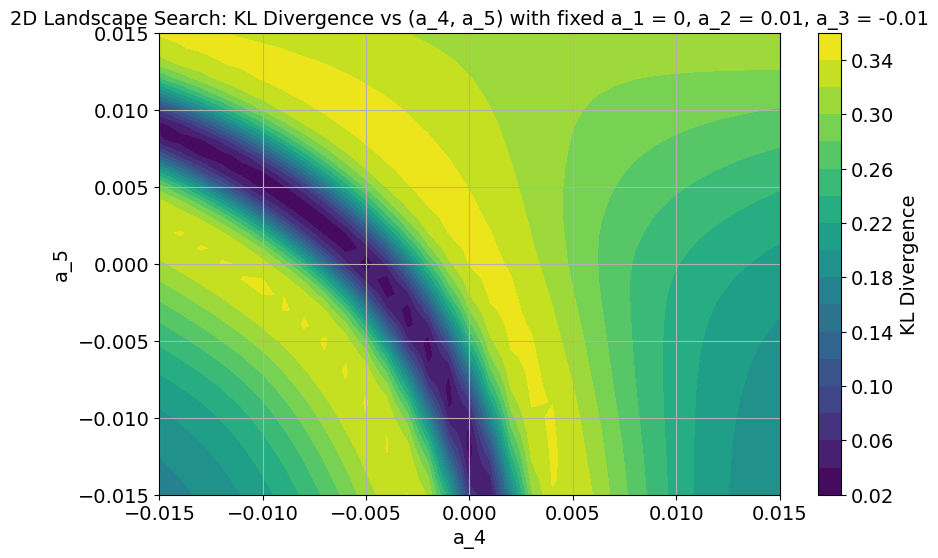

In [15]:
# Define the ranges for a_4 and a_5
a_4_values = np.linspace(-0.015, 0.015, 31)  # 31 points between -0.015 and 0.015
a_5_values = np.linspace(-0.015, 0.015, 31)  # 31 points between -0.015 and 0.015

# Perform the 2D landscape search for a_4 and a_5
results = run_landscape_search_2d_fixed_a1_a2_a3(f_iv, f_eq, a_4_values, a_5_values)

# Plot the 2D landscape search results
plot_2d_landscape(results)

In [10]:
# Computing the Jacobian with reverse mode differentiation. This should take a bit, and take a large amount of memory.

def wrapper_vlassov_poison_solver(H:Array) -> Array:
  f_final, _ = solver_jit(jnp.array(f_iv), H, t_final=40.0)
  return f_final

In [12]:
#jacobian_fn = jax.jacfwd(wrapper_vlassov_poison_solver, argnums=0)
#jacobian = jacobian_fn(H)
# checking the shape of the jacobian, as f is a 2-tensor and H is a 1-tensor. The output should be a 3-tensor.
#jacobian.shape

In [11]:
a_1 = 1.0
a_2 = 0.5
a_3 = -0.5

xs = np.linspace(0, L, nx, endpoint=False)

H_init = a_1 * np.cos(xs / L * 2 * np.pi) +\
        a_2 * np.cos(2 * xs / L * 2 * np.pi) +\
        a_3 * np.cos(3 * xs / L * 2 * np.pi)

In [15]:
def objective_fun_L2(H, f_eq):
    f_final = wrapper_vlassov_poison_solver(H)
    return 0.5*jnp.linalg.norm(jnp.linalg.norm(f_final - f_eq,axis=0)**2)**2


#def objective_fun_KL(H, f_eq):
#    f_final = wrapper_vlassov_poison_solver(H)
#    return calculate_kl_divergence(f_final, f_eq)

#def objective_fun_KL_jax(H, f_eq):
#    f_final = wrapper_vlassov_poison_solver(H)
#    return calculate_kl_divergence_jax(f_final, f_eq)

In [16]:
wrapper_objective_fun_L2 = partial(objective_fun_L2, f_eq=f_eq)

In [17]:
print(wrapper_objective_fun_L2(H_init))

102.44844


In [18]:
gradient = jax.grad(wrapper_objective_fun_L2,argnums=0)

In [19]:
grad = gradient(H)

In [20]:
grad.shape

(256,)

In [21]:
opt_H_restults = optimize.minimize(wrapper_objective_fun_L2, H_init, args=(), method='BFGS')

/grad/mguerra4/miniconda3/envs/vlasov-poisson/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5908: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  output = _eye(N, M=M, k=k, dtype=dtype)
/grad/mguerra4/miniconda3/envs/vlasov-poisson/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [22]:
opt_H_restults.x

Array([ 0.8866077 ,  0.8606551 ,  0.8588326 ,  0.85305077,  0.85580707,
        0.85442996,  0.8733847 ,  0.86754864,  0.8818054 ,  0.8331601 ,
        0.72130656,  0.61470807,  0.5982303 ,  0.5862745 ,  0.5512626 ,
        0.47595865,  0.47802222,  0.41787687,  0.36950707,  0.5769171 ,
        0.5184392 ,  0.12929976, -0.48259133, -0.57332915,  0.00360262,
        1.0843234 ,  1.3978723 ,  1.3092319 ,  1.0087433 ,  0.89969796,
        0.9275375 ,  0.7829893 ,  0.5822486 ,  0.47938952,  0.42401156,
        0.26725996,  0.13241905,  0.04382974,  0.03214207,  0.03648154,
        0.03739986,  0.00715445,  0.00943082,  0.02162056, -0.09612758,
       -0.13322143, -0.09154016,  0.03540924,  0.18484521,  0.21700066,
        0.20068789,  0.17695695,  0.06647937,  0.03545305,  0.00791993,
       -0.04055317,  0.00672169, -0.08672169, -0.1401354 , -0.26811367,
       -0.4344145 , -0.48440504, -0.44624892, -0.2900011 , -0.1980032 ,
       -0.1988173 , -0.36146066, -0.42560813, -0.44065234, -0.38

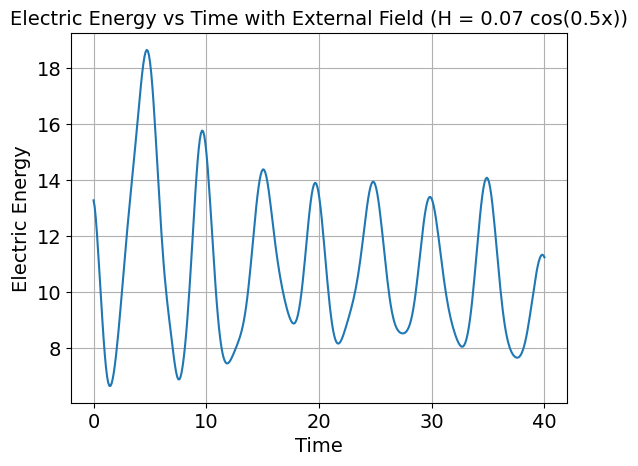

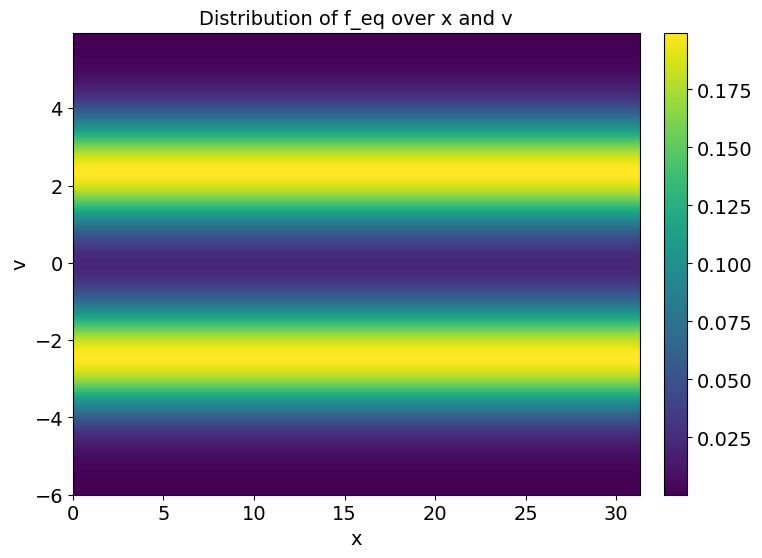

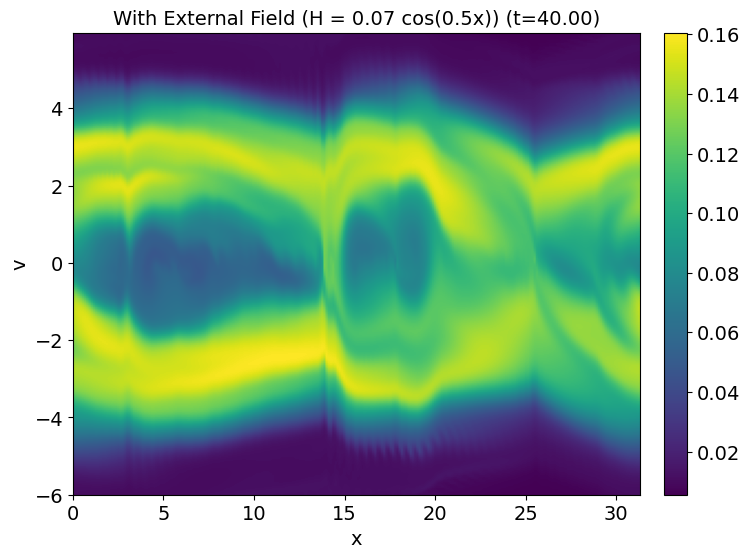

In [24]:
# Run the forward simulation with the updated external field
f_final, (f_array, E_array, ee_array) = solver_jit(jnp.array(f_iv), opt_H_restults.x, t_final=40.0)

# Plotting the electric energy with respect to time
plt.plot(t_values, ee_array)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time with External Field (H = 0.07 cos(0.5x))')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution for the final step with the external field
plot_distribution(ax, f_array, num_steps - 1, 'With External Field (H = 0.07 cos(0.5x))', t_final)

# Display the plot
plt.show()